## Importing data and libraries

In [1]:
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key

nasdaqdatalink.ApiConfig.api_key ='dHi3RFzR578TvS7sJ9aB'

In [3]:
data = nasdaqdatalink.get_table("QDL/OPEC", paginate=True)

In [4]:
data.head()

,date,value
None,,
0,2024-01-25,81.98
1,2024-01-24,81.05
2,2024-01-23,81.30
3,2024-01-22,79.70
4,2024-01-19,80.27


In [5]:
data.shape

(5435, 2)

In [6]:
data.columns

Index(['date', 'value'], dtype='object')

In [7]:
# Subsetting data

data_sub = data.loc[(data['date'] >= '2020')]

In [8]:
# Set the "Date" column as the index
data_sub['date'] = pd.to_datetime(data_sub['date'])
data_sub = data_sub.set_index('date')
data_sub.head()

,value
date,
2024-01-25,81.98
2024-01-24,81.05
2024-01-23,81.30
2024-01-22,79.70
2024-01-19,80.27


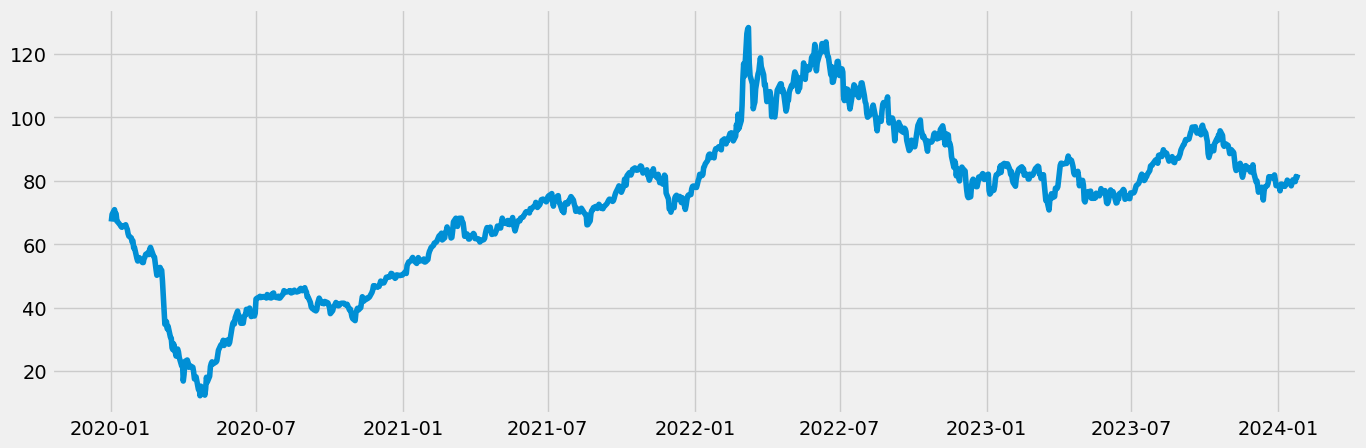

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data_sub)

## Time-series analysis: decomposition

In [10]:
# Decompose the time series using an additive model with the specified period
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period=12)

In [11]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

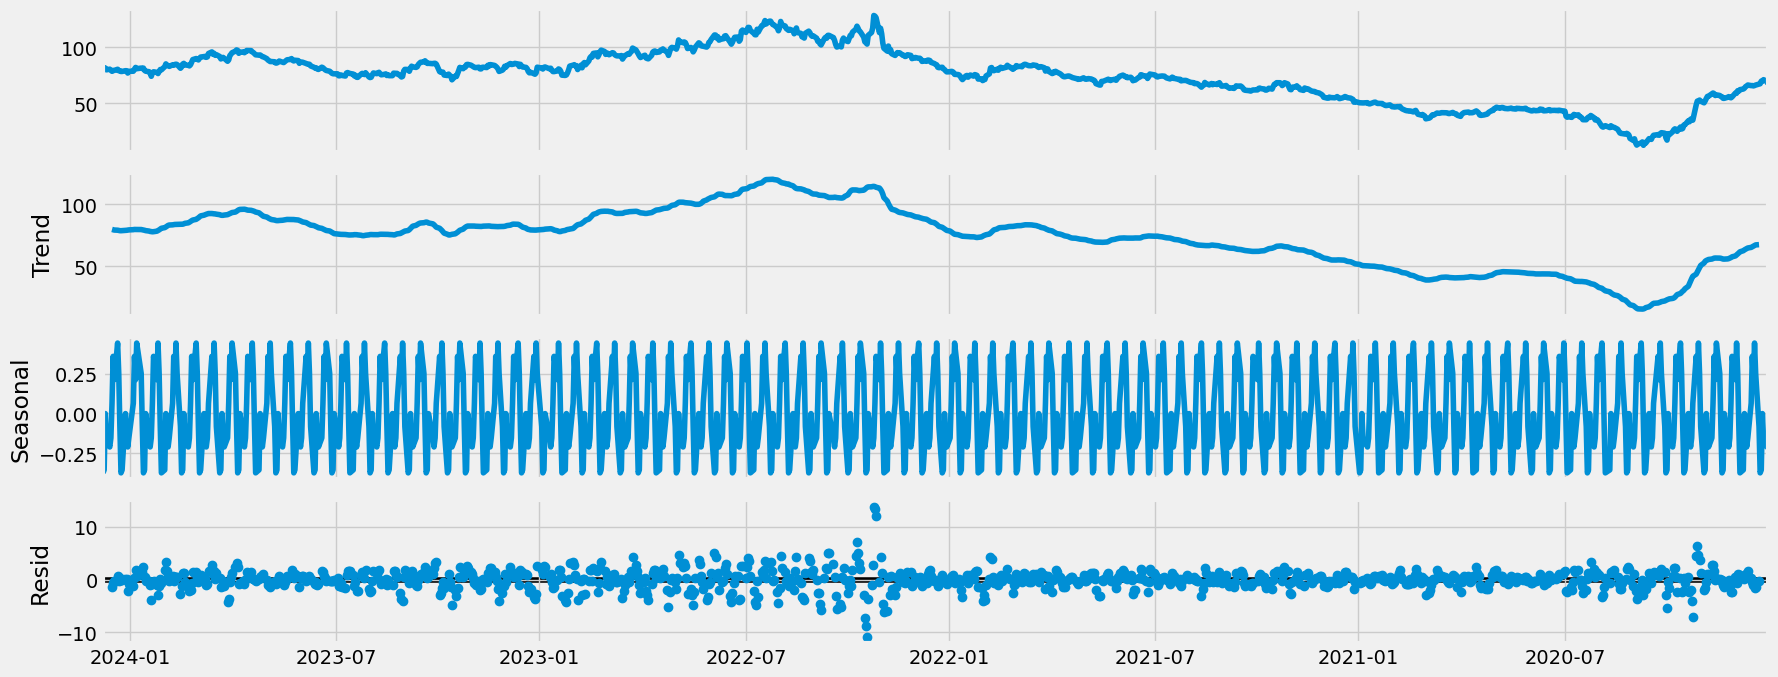

In [12]:
# Plot the separate components

decomposition.plot()
plt.show()

Trend: This top graph shows a relatively stable trend, with slight fluctuations over time.

Seasonal: The middle graph illustrates a clear seasonal pattern, repeating regularly with highs and lows, indicating the presence of seasonality.

Residual: The bottom graph plots residuals, which are the differences between the observed values and those predicted by the model. The residuals mostly cluster around zero.

## Testing for stationarity using Dickie-Fuller test

In [13]:
#Changing data_sub dataset to df for ease of use
df= data_sub

In [14]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df['value'])

Dickey-Fuller Stationarity test:
Test Statistic                   -1.480551
p-value                           0.543110
Number of Lags Used              17.000000
Number of Observations Used    1032.000000
Critical Value (1%)              -3.436702
Critical Value (5%)              -2.864345
Critical Value (10%)             -2.568263
dtype: float64


Since test statistic is greater than the critical values, indicates that there is a unit root and we can't reject the null hypothesis and the data is non-stationary. 

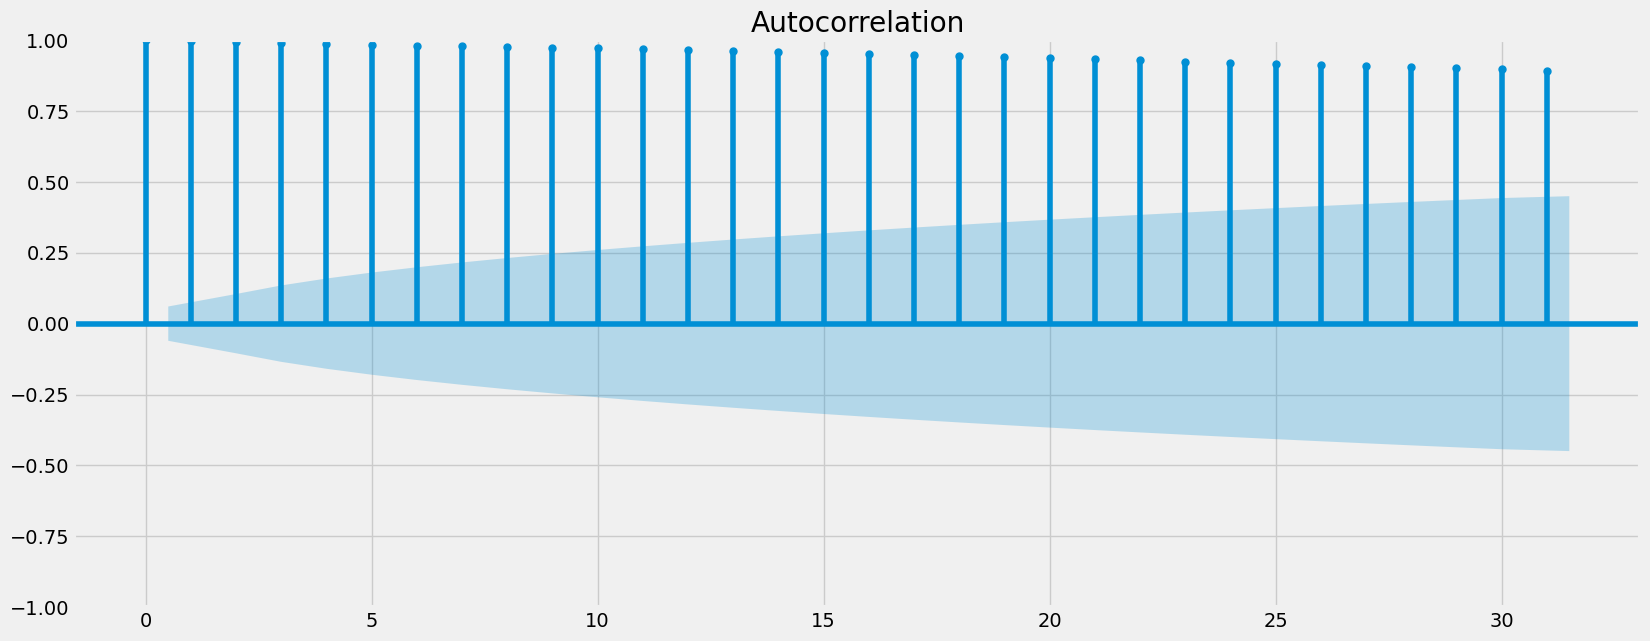

In [15]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

As we can see the line are going above the blue edge of the confidence interval meaning there are lags that are significantly correlated wiith each other indicating that the time series is non-stationary. 

## Stationarizing the data

In [16]:
# Stationarizing using differencing

data_diff = df - df.shift(1)

In [17]:
# Remove the missing values that result from differencing.

data_diff.dropna(inplace = True)

In [18]:
data_diff.head()

,value
date,
2024-01-24,-0.93
2024-01-23,0.25
2024-01-22,-1.60
2024-01-19,0.57
2024-01-18,-0.88


In [19]:
data_diff.columns

Index(['value'], dtype='object')

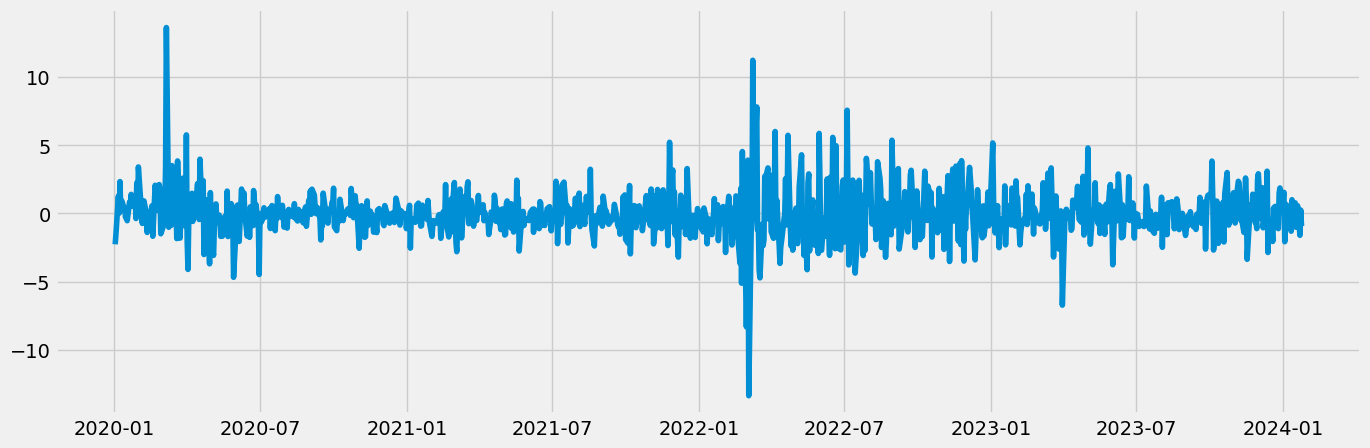

In [20]:
# How did the differencing change the time-series curve?

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

## Re-running the Dickie-Fuller test


In [21]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.396722e+00
p-value                        2.042203e-08
Number of Lags Used            1.600000e+01
Number of Observations Used    1.032000e+03
Critical Value (1%)           -3.436702e+00
Critical Value (5%)           -2.864345e+00
Critical Value (10%)          -2.568263e+00
dtype: float64


The test statistics being more negative than the critical values and a low p-value (close to zero) and below 0.05 indicates that we can now reject the null hypothesis and consider the data stationary.

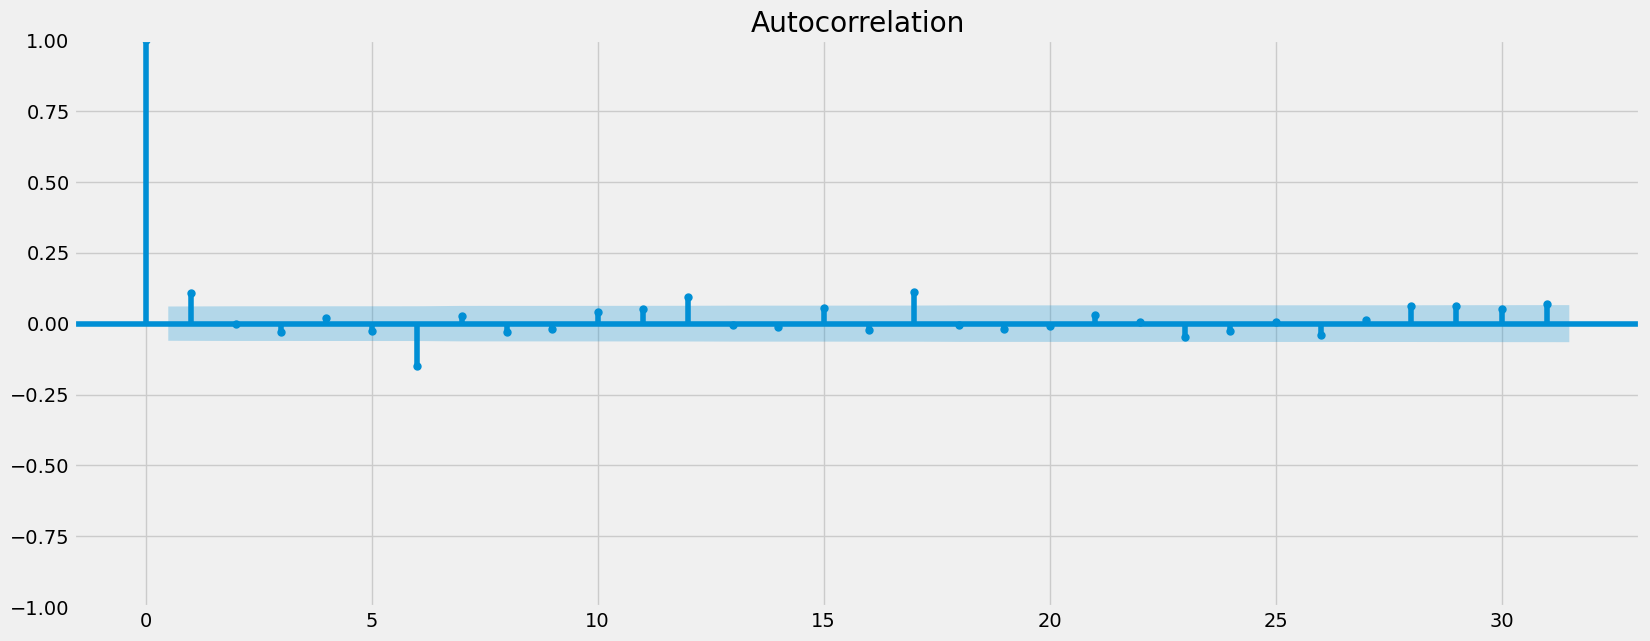

In [22]:
# Check plot again for autocorrelations

plot_acf(data_diff)
plt.show()

Based on the autocorrelation chart, it's evident that the autocorrelations are now minimal, indicating strong stationarity in the data.